## Importing libraries

In [26]:
import gc #garbage collector
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pylab

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from helper import utility as ut
import importlib
importlib.reload(ut)

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb


## Load Dataset

In [27]:
prop_2016 = ut.load_properties_data('clean_data/prop_2016_clean.csv')
prop_2017 = ut.load_properties_data('clean_data/prop_2017_clean.csv')
train = ut.load_properties_data('clean_data/train_combined.csv')

train.dtypes

parcelid                       int64
logerror                     float64
airconditioningtypeid          int64
architecturalstyletypeid       int64
basementsqft                 float64
                              ...   
avg_area_per_room            float64
derived_avg_area_per_room    float64
year                           int64
month                          int64
quarter                        int64
Length: 71, dtype: object

## Catboost Model

In [28]:
# Dropping columns which do not perform well when we input to the catboost model
catboost_features = ut.drop_features(train)
print("Number of features for CatBoost: {}".format(len(catboost_features.columns)))
catboost_features.head(5)

# Prepare feature list for catboost model
categorical_features = ['airconditioningtypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'year', 'month', 'quarter','buildingclasstypeid']
for col in catboost_features.columns:
    if col in categorical_features:
        catboost_features[col] = catboost_features[col].astype('str')

Number of features for CatBoost: 55


In [29]:
# Prepare training and cross-validation data
catboost_label = train.logerror.astype(np.float32)
print(catboost_label.head())

# Transform to Numpy matrices
catboost_X = catboost_features.values
catboost_y = catboost_label.values

# Perform shuffled train/test split
X_train, X_val, y_train, y_val = train_test_split(catboost_X, catboost_y, test_size=0.2 , random_state=99)

ut.remove_outliers(X_train, y_train)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
new_X: (131462, 55)
new_y: (131462,)
X_train shape: (134310, 55)
y_train shape: (134310,)
X_val shape: (33578, 55)
y_val shape: (33578,)


In [30]:
# Specify feature names and categorical features for CatBoost
categorical_indices = ut.get_categorical_indices(catboost_features, categorical_features)

[0, 13, 21, 52, 53, 54]


In [31]:
ut.remove_outliers(catboost_X, catboost_y)

model = CatBoostRegressor(    
    loss_function='MAE',
    eval_metric='MAE',
    nan_mode='Min',
    random_seed=99,
    iterations=1000,
    learning_rate=0.015,
    border_count=254,
    max_depth=6,
    random_strength=1,
    l2_leaf_reg=5,
    bagging_temperature=1,
    verbose=True
    )
model.fit(catboost_X, catboost_y, cat_features=categorical_indices, verbose=False)

# Sanity check: score on a small portion of the dataset
print("sanity check score: {}".format(abs(model.predict(X_val) - y_val).mean()))

new_X: (164299, 55)
new_y: (164299,)
sanity check score: 0.06857669115730533


In [32]:
file_name = 'submission/final_catboost_single.csv'
submission, pred_2016, pred_2017 = ut.predict_and_export([model], prop_2016, prop_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0130 -0.0130 -0.0130 -0.0159 -0.0159 -0.0159
1  10759547 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121
2  10843547  0.0040  0.0040  0.0040  0.0075  0.0075  0.0075
3  10859147  0.0277  0.0277  0.0277  0.0293  0.0293  0.0293
4  10879947  0.0105  0.0105  0.0105  0.0100  0.0100  0.0100


## Lightgbm

In [33]:
lightgbm_features = ut.drop_features(train)
print("Number of features for Lightgbm: {}".format(len(lightgbm_features.columns)))
lightgbm_features.head(5)

Number of features for Lightgbm: 55


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet50,finishedsquarefeet6,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,avg_garage_size,property_tax_per_sqft,coord_1,coord_2,coord_3,coord_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,total_room_cnt,avg_area_per_room,derived_avg_area_per_room,year,month,quarter
0,0,2.0,3.0,4.0,NaN,1684.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13,NaN,3.999929,-84207544.0,152769540.0,4658858.0,63903126.0,0.0,1.0,0.0,5.0,NaN,336.80000,0,1,1
1,-1,3.5,4.0,NaN,NaN,2263.0,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677550.0,3643.0,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN,234.0,4.486531,-84009430.0,151345660.0,4248732.0,63087508.0,0.0,1.0,0.0,7.5,NaN,301.73334,0,1,1
2,0,3.0,2.0,4.0,NaN,2217.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136310.0,-118175030.0,11423.0,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13,NaN,5.180190,-84038720.0,152311340.0,4592554.0,63680070.0,0.0,1.0,0.0,5.0,NaN,443.40000,0,1,1
3,0,2.0,2.0,4.0,NaN,839.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13,NaN,3.633778,-84553200.0,152064800.0,4178550.0,63333050.0,0.0,1.0,0.0,4.0,NaN,209.75000,0,1,1
4,-1,2.5,4.0,NaN,NaN,2283.0,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700230.0,6000.0,1.0,NaN,NaN,1.0,230,60590424.0,17686.0,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13,299.0,2.404275,-84214590.0,151185870.0,4060586.0,62910702.0,0.0,1.0,0.0,6.5,285.375,351.23077,0,1,1


In [34]:
# Prepare training and cross-validation data
lightgbm_label = train.logerror.astype(np.float32)
print(lightgbm_label.head())

# Transform to Numpy matrices
lightgbm_X = lightgbm_features.values
lightgbm_y = lightgbm_label.values

# Perform shuffled train/test split
np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lightgbm_X, lightgbm_y, test_size=0.2 , random_state=99)

a,b=ut.remove_outliers(X_train, y_train)
X_train=a
y_train=b

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
new_X: (131462, 55)
new_y: (131462,)
X_train shape: (131462, 55)
y_train shape: (131462,)
X_val shape: (33578, 55)
y_val shape: (33578,)


In [35]:
# Specify feature names and categorical features for Lightgbm
categorical_features = ['airconditioningtypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'year', 'month', 'quarter','buildingclasstypeid']
categorical_indices = ut.get_categorical_indices(lightgbm_features, categorical_features)

[0, 13, 21, 52, 53, 54]


In [36]:
#Lightgbm parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 1250
params['learning_rate'] = 0.003  # shrinkage_rate
params['early_stopping_rounds'] = 30  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 127  # max number of leaves in one tree (default 31)
params['min_data'] = 150  # min_data_in_leaf
params['min_hessian'] = 0.001  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.5    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.7
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

### Train Single Model

In [45]:
#Train Lightgbm
feature_names = [s for s in lightgbm_features.columns]
lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on train and validation sets
print("Train score: {}".format(abs(model.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7058
[LightGBM] [Info] Number of data points in the train set: 131462, number of used features: 55
[LightGBM] [Info] Start training from score 0.007717
Train score: 5.0463713269426576
Val score: 6.891177954306797


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

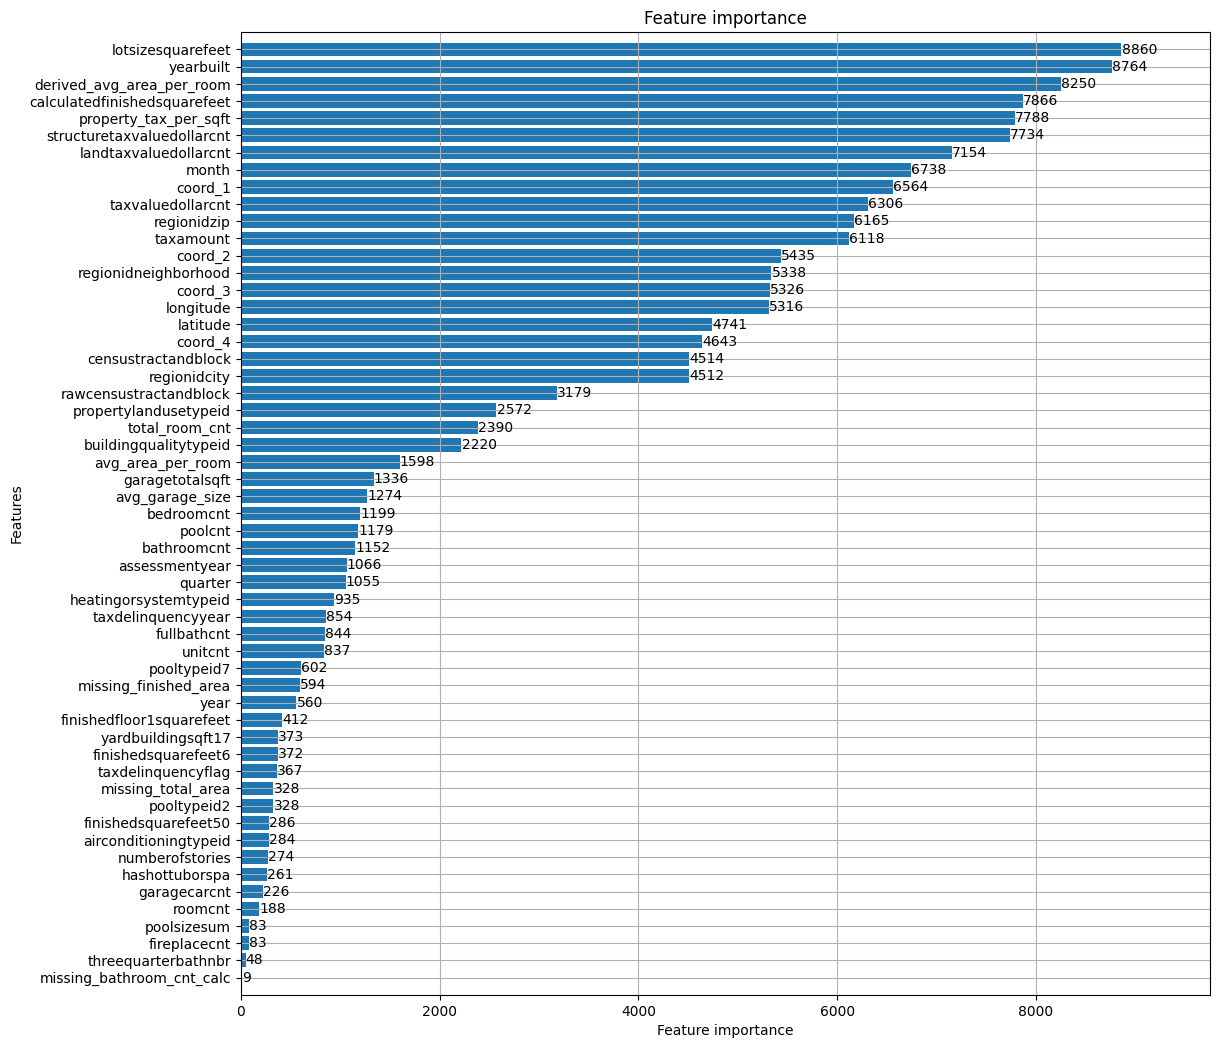

In [46]:
# Plot LightGBM feature importance
lgb.plot_importance(model, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [48]:
# Train LightGBM on all given training data (preparing for submission)
#del params['early_stopping_rounds']

a,b=ut.remove_outliers(lightgbm_X,lightgbm_y)
lightgbm_X=a
lightgbm_y=b

lgb_train_set = lgb.Dataset(lightgbm_X, label=lightgbm_y, feature_name=feature_names)
print("lightgbm_X: {}".format(lightgbm_X.shape))
print("lightgbm_y: {}".format(lightgbm_y.shape))

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set, categorical_feature=categorical_indices)

# Sanity check: make sure the model score is reasonable on a small portion of the data
print("score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

new_X: (164299, 55)
new_y: (164299,)
lightgbm_X: (164299, 55)
lightgbm_y: (164299,)
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7132
[LightGBM] [Info] Number of data points in the train set: 164299, number of used features: 55
[LightGBM] [Info] Start training from score 0.007873
score: 6.782469378648226


In [49]:
file_name = 'submission/final_lgb_single.csv'
submission, pred_2016, pred_2017 = ut.predict_and_export([model], prop_2016, prop_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0209 -0.0209 -0.0209 -0.0167 -0.0167 -0.0167
1  10759547 -0.0164 -0.0164 -0.0164 -0.0148 -0.0148 -0.0148
2  10843547  0.0144  0.0144  0.0144  0.0235  0.0235  0.0235
3  10859147  0.0250  0.0250  0.0250  0.0248  0.0248  0.0248
4  10879947 -0.0017 -0.0017 -0.0017 -0.0012 -0.0012 -0.0012


### Train ensemble model 

In [54]:
# Remove outliers (if any) from training data
a,b=ut.remove_outliers(lightgbm_X,lightgbm_y)
lightgbm_X=a
lightgbm_y=b

lgb_train_set = lgb.Dataset(lightgbm_X, label=lightgbm_y, feature_name=feature_names)

# Train multiple models
bags = 5
models = []
for i in range(bags):
    print("Start training model {}".format(i))
    params['seed'] = i
    np.random.seed(42)
    random.seed(36)
    model = lgb.train(params, lgb_train_set, categorical_feature=categorical_indices)
    models.append(model)
    
# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print("model {}: {}".format(i, abs(model.predict(X_val) - y_val).mean() * 100))

# Save the trained models to disk
ut.save_models(models,'lightgbm')

models = ut.load_lightgbm_models(['checkpoints/lightgbm_' + str(i) for i in range(5)])  # load pretrained models

new_X: (164299, 55)
new_y: (164299,)
Start training model 0
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7132
[LightGBM] [Info] Number of data points in the train set: 164299, number of used features: 55
[LightGBM] [Info] Start training from score 0.007873
Start training model 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7132
[LightGBM] [Info] Number of data points in the train set: 164299, number o

In [55]:
# Make predictions and export results
file_name = 'submission/final_lgb_ensemble_x5.csv'
submission, pred_2016, pred_2017 = ut.predict_and_export(models, prop_2016, prop_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Start model 1 (2016)
Start model 1 (2017)
Start model 2 (2016)
Start model 2 (2017)
Start model 3 (2016)
Start model 3 (2017)
Start model 4 (2016)
Start model 4 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0209 -0.0209 -0.0209 -0.0167 -0.0167 -0.0167
1  10759547 -0.0164 -0.0164 -0.0164 -0.0148 -0.0148 -0.0148
2  10843547  0.0144  0.0144  0.0144  0.0235  0.0235  0.0235
3  10859147  0.0250  0.0250  0.0250  0.0248  0.0248  0.0248
4  10879947 -0.0017 -0.0017 -0.0017 -0.0012 -0.0012 -0.0012


## Stacking

In [57]:
lgb_single = pd.read_csv('submission/final_lgb_single.csv')
catboost_x8 = pd.read_csv('submission/final_catboost_single.csv')
print("Finished Loading the prediction results.")

weight = 0.7
stack = pd.DataFrame()
stack['ParcelId'] = lgb_single['ParcelId']
for col in ['201610', '201611', '201612', '201710', '201711', '201712']:
    stack[col] = weight * catboost_x8[col] + (1 - weight) * lgb_single[col]

print(stack.head())
stack.to_csv('submission/final_stack.csv', index=False)

Finished Loading the prediction results.
   ParcelId   201610   201611   201612   201710   201711   201712
0  10754147 -0.01537 -0.01537 -0.01537 -0.01614 -0.01614 -0.01614
1  10759547 -0.01339 -0.01339 -0.01339 -0.01291 -0.01291 -0.01291
2  10843547  0.00712  0.00712  0.00712  0.01230  0.01230  0.01230
3  10859147  0.02689  0.02689  0.02689  0.02795  0.02795  0.02795
4  10879947  0.00684  0.00684  0.00684  0.00664  0.00664  0.00664
